# Inelastic Radiative Transfer Calculation with MC

In this example we perform a full radiative transfer calculation that includes rotational Raman scattering. The "inelastic radiance" (with full Raman scatter) is plotted alongside the "elastic radiance" (which neglects the wavelength shifts of Raman scatter) in the presence of deep Fraunhofer lines. 

In [1]:
%matplotlib inline

In [2]:
import sasktran as sk
import matplotlib.pyplot as plt
import numpy as np
from sasktran.geometry import VerticalImage

# First recreate our geometry and atmosphere classes
geometry = VerticalImage()
geometry.from_sza_saa(sza=60, saa=60, lat=0, lon=0, tanalts_km=[20], mjd=54372, locallook=0,
                      satalt_km=600, refalt_km=20)

atmosphere = sk.Atmosphere()
atmosphere['ozone'] = sk.Species(sk.O3OSIRISRes(), sk.Labow())
atmosphere['air'] = sk.Species(sk.InelasticRayleigh(), sk.MSIS90())
atmosphere.brdf = 1.0

# And now make the engine
engine = sk.EngineMC(geometry=geometry, atmosphere=atmosphere)

engine.max_photons_per_los = 1000  # cap the calculation at 300 rays per line of sight
engine.solar_table_type = 0        # calculate single scatter source terms on the fly; no cache
engine.debug_mode = 1234           # disable multi-threading and fix the rng seed for reproduceable results
engine.simultaneous_wavelength = True        # enable simultaneous wavelength mode

# calculate the elastic radiance in parallel
engine.secondary_output = 1
# wavelengths where the optical properties are cached
engine.optical_property_wavelengths = np.arange(385., 407., 0.5)
# incident solar spectrum
engine.solar_irradiance = sk.SolarSpectrum().irradiance(engine.optical_property_wavelengths, fwhm=1)  

# Choose some wavelengths to do the calculation at
engine.wavelengths = np.arange(391.0, 400.0, 0.5)

# And do the calculation
engine_output = engine.calculate_radiance()

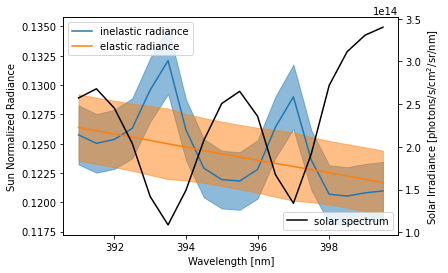

In [3]:
# interpolate the solar spectrum to the radiance grid for normalization
wl = engine.wavelengths
solar = np.interp(wl, engine.optical_property_wavelengths, engine.solar_irradiance)

# plot inelastic radiance
rad = engine_output.radiance[:, 0] / solar
stdev = np.sqrt(engine_output.radiance_variance[:, 0]) / solar
plt.plot(wl, rad, 'C0', label='inelastic radiance')
plt.fill_between(wl, rad - stdev, rad + stdev, color='C0', alpha=0.5)

# plot elastic radiance
rad = engine_output.elastic_radiance[:, 0] / solar
stdev = np.sqrt(engine_output.elastic_radiance_variance[:, 0]) / solar
plt.plot(wl, rad, 'C1', label='elastic radiance')
plt.fill_between(wl, rad - stdev, rad + stdev, color='C1', alpha=0.5)

plt.xlabel('Wavelength [nm]')
plt.ylabel('Sun Normalized Radiance')
plt.legend(loc=2)

# plot solar spectrum for reference
plt.gca().twinx()
plt.plot(wl, solar, 'k', label='solar spectrum')

plt.ylabel('Solar Irradiance [photons/s/cm$^2$/sr/nm]')
plt.legend(loc=4)

plt.show()